In [1]:
import pickle
X_hr,y_stress,y_participant,X_time = pickle.load(open('../data/tabular_data_60_seconds_ppg_rr_dalia_normalized.p','rb'))

X_hr = X_hr.reshape(-1,30,1)

import tensorflow as tf
# tf.debugging.set_log_device_placement(True)

# strategy = tf.distribute.MirroredStrategy()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut,LeavePGroupsOut
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import backend as K 
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib notebook
from keras.layers import Conv1D,Reshape,BatchNormalization,TimeDistributed, \
Dropout,Input,MaxPooling1D,Flatten,Dense,Input, GaussianNoise,LSTM, Bidirectional, Input
from keras.models import Model, Sequential
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer,LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances

train_participant = y_participant.copy()

print(np.unique(y_participant),train_participant.shape)

train_x = X_hr
train_y = y_participant

train_x, test_x, train_y, test_y,participant_ids_train, participant_ids_test = train_test_split(X_hr,
                                                            train_participant,
                                                            y_participant,
                                                            test_size = 0.2,
                                                            random_state=41,
                                                            stratify=y_participant)
train_x, val_x, train_y, val_y, participant_ids_train, participant_ids_val  = train_test_split(train_x,
                                                            train_y,
                                                            participant_ids_train,
                                                            test_size = 0.1,
                                                            random_state=41,
                                                            stratify=participant_ids_train)
# train_x.shape,test_x.shape,val_x.shape,train_y.shape,test_y.shape,val_y.shape,participant_ids_train.shape


# def custom_loss(y_true,y_pred):
    
# #     print(y_true.shape)
# #     print(y_pred[0].shape)
# #     y_pred_output_class = y_pred
# #     [0]
# #     y_pred_output_embedding = y_pred[1]
#     return tf.keras.losses.SparseCategoricalCrossentropy(y_true,y_pred_output_class) 
# + tfa.losses.TripletSemiHardLoss(y_true,y_pred_output_embedding)


def custom_loss(embeddings):
    def loss(y_true,y_pred):
        return tf.keras.losses.SparseCategoricalCrossentropy(y_true,y_pred)
    return loss


def get_model(input_shape=(30,1),act='relu',loss="categorical_crossentropy",opt='adam',
              n_classes=350,n_output = 15):
    
    model =  Sequential()
    model.add(Input(shape=input_shape))
    model.add(Reshape(input_shape))
    model.add(Conv1D(100,10,input_shape=input_shape,activation='linear',kernel_initializer='normal',padding='same'))
    model.add(Conv1D(100,10,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(200,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(300,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Conv1D(50,2,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Flatten())
#     model.add(Dense(n_classes//2,activation='relu'))
    model.add(Dense(n_output//2,activation='relu'))
#     model.add(Dense(n_classes,activation='softmax',kernel_initializer='normal'))
    
    input_ = Input(shape=input_shape)
    embeddings = model(input_)
    #     print(embeddings.shape)
    softmax_activations = Dense(n_output,activation='sigmoid',name='feature1')(embeddings)
    softmax_activations = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1),name='feature')(softmax_activations)
    softmax_output = Dense(n_output,activation='softmax',name='output')(softmax_activations)
    model1 = Model(inputs=[input_],outputs=[softmax_output,softmax_activations])
    model1.compile(loss={'feature':tfa.losses.TripletSemiHardLoss(),'output':tf.keras.losses.SparseCategoricalCrossentropy()},
                   optimizer=opt,
                  loss_weights={'feature':1,'output':1})
    return model1

n_classes = 200
n_output = len(np.unique(y_participant))
model = get_model(input_shape=(30,1),n_classes=n_classes,n_output=n_output) 
model.summary()

# model.layers[0]

from keras.models import load_model
filepath = '../model_files/base_cnn_60_seconds_ppg_hr_wesad_normalized.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_output_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_output_loss', mode='min', verbose=1,patience=40)
callbacks_list = [es,checkpoint]
history = model.fit(train_x,[train_y,train_y],validation_data=(val_x,[val_y,val_y]), epochs=400, 
                    batch_size=500,callbacks=callbacks_list,shuffle=True,verbose=1)

# # # model = load_model(filepath)

4 Physical GPUs, 1 Logical GPU
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] (64247,)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
sequential (Sequential)      (None, 7)                 934707    
_________________________________________________________________
feature1 (Dense)             (None, 15)                120       
_________________________________________________________________
feature (Lambda)             (None, 15)                0         
_________________________________________________________________
output (Dense)               (None, 15)                240       
Total params: 935,067
Trainable params: 933,767
Non-trainable params: 1,300
_________________________________________________________________
Epoch 1/400
93/93 [===========

In [6]:
test_embeddings = model.predict(test_x)[1]
test_y_pred = model.predict(test_x)[0].argmax(axis=1)

In [7]:
from sklearn.metrics import confusion_matrix,classification_report

In [8]:
print(classification_report(test_y,test_y_pred))
print(confusion_matrix(test_y,test_y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       898
           1       0.99      0.98      0.99       909
           2       0.95      0.97      0.96       787
           3       0.95      0.97      0.96       868
           4       0.97      0.96      0.96       928
           5       0.99      0.97      0.98       785
           6       0.89      0.99      0.94       518
           7       0.93      0.98      0.95       907
           8       0.99      0.98      0.98      1058
           9       0.98      0.95      0.97       924
          10       0.98      0.99      0.98       849
          11       1.00      0.97      0.98       801
          12       0.98      0.97      0.97       814
          13       0.97      0.96      0.97       889
          14       0.98      0.96      0.97       915

    accuracy                           0.97     12850
   macro avg       0.97      0.97      0.97     12850
weighted avg       0.97   

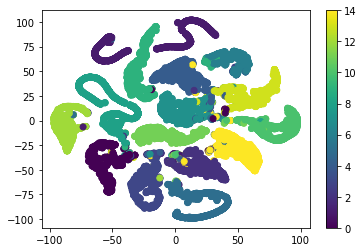

In [9]:
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
train_embeddings_pca = TSNE(n_components=2).fit_transform(test_embeddings)
plt.figure()
plt.scatter(train_embeddings_pca[:,0],train_embeddings_pca[:,1],c=test_y)
plt.colorbar()
plt.show()

In [10]:
import pickle
test_dalia_x,test_dalia_y_stress,test_dalia_y,test_dalia_time = pickle.load(open('../data/tabular_data_60_seconds_ppg_rr_normalized.p',
                                                                                 'rb'))

In [11]:
test_dalia_x = test_dalia_x.reshape(-1,30,1)

In [12]:
test_dalia_embeddings = model.predict(test_dalia_x)[1]
test_dalia_y_pred = model.predict(test_dalia_x)[0].argmax(axis=1)

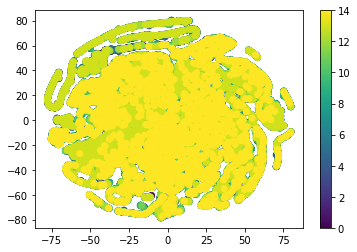

In [13]:
train_embeddings_pca = TSNE(n_components=2).fit_transform(test_dalia_embeddings)
plt.figure()
plt.scatter(train_embeddings_pca[:,0],train_embeddings_pca[:,1],c=test_dalia_y)
plt.colorbar()
plt.show()

In [ ]:
model = get_model(input_shape=(30,1),n_classes=n_classes,n_output=n_output,loss=custom_loss) 
model.summary()
model.load_weights(filepath)

In [ ]:
y_pred = model.predict(test_x).argmax(axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print(confusion_matrix(test_y,y_pred))

In [ ]:
%matplotlib inline
def get_clusters(model,train_x,train_y):
    train_embeddings = model.predict(train_x)

    from sklearn.decomposition import PCA

    train_embeddings_pca = PCA(n_components=20).fit_transform(train_embeddings)

    plt.figure()
    plt.scatter(train_embeddings_pca[:,0],train_embeddings_pca[:,1],c=train_y)
    plt.show()
get_clusters(model,test_x,test_y)

In [ ]:
import pickle
test_dalia_x,test_dalia_y_stress,test_dalia_y,test_dalia_time = pickle.load(open('../data/tabular_data_60_seconds_ppg_rr_dalia.p',
                                                                                 'rb'))
test_dalia_x = test_dalia_x.reshape(-1,30,1)
get_clusters(model,test_dalia_x,test_dalia_y)

In [ ]:
def give_rank_accuracy(train_embeddings,train_y,rank = 10):
    distance_matrix = euclidean_distances(train_embeddings)
    distance_matrix_2d = np.zeros((distance_matrix.shape[0],
                               distance_matrix.shape[0],
                               2))
    distance_matrix_2d[:,:,0] = distance_matrix
    train_y_matrix = np.concatenate([train_y.reshape(1,-1)]*distance_matrix.shape[0])
    distance_matrix_2d[:,:,1] = train_y_matrix
    match = 0
    for i in range(distance_matrix.shape[0]):
        row = distance_matrix_2d[i]
        row = row[row[:,0].argsort(),:]
        if rank==1:
            if train_y[i]==row[1,1]:
                match+=1
        else:
            row = set(row[1:(rank+1)][:,1])
            if train_y[i] in row:
                match+=1
    return match/distance_matrix.shape[0]

In [ ]:
rank_1 = give_rank_accuracy(train_embeddings,train_y,rank = 1)
rank_5 = give_rank_accuracy(train_embeddings,train_y,rank = 5)
rank_10 = give_rank_accuracy(train_embeddings,train_y,rank = 10)
print(rank_1,rank_5,rank_10)

In [ ]:
test_embeddings = model.predict(test_x)

In [ ]:
rank_1 = give_rank_accuracy(test_embeddings,test_y,rank = 1)
rank_5 = give_rank_accuracy(test_embeddings,test_y,rank = 5)
rank_10 = give_rank_accuracy(test_embeddings,test_y,rank = 10)
print(rank_1,rank_5,rank_10)

In [ ]:
test_x,y_stress,test_y,X_time = pickle.load(open('../data/tabular_data_60_seconds_ppg_rr_dalia.p','rb'))

In [ ]:
test_x = test_x.reshape(-1,30,1)

In [ ]:
test_embeddings = model.predict(test_x)
rank_1 = give_rank_accuracy(test_embeddings,test_y,rank = 1)
rank_5 = give_rank_accuracy(test_embeddings,test_y,rank = 5)
rank_10 = give_rank_accuracy(test_embeddings,test_y,rank = 10)
print(rank_1,rank_5,rank_10)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(train_y,train_y_pred))
print(confusion_matrix(train_y,train_y_pred))